In [1]:
from rbm import RBM
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import time
import math
import argparse
import pickle
import os

In [2]:
def binary_data(inp):
    return (inp > 0.5) * 1.

def shuffle_corpus(data):
    """shuffle the corpus randomly
    Args:
        data: the image vectors, [num_images, image_dim]
    Returns: The same images with different order
    """
    random_idx = np.random.permutation(len(data))
    return data[random_idx]

<h2>Train</h2>

In [ ]:
np.seterr(all='raise')

epochs = 100
n_hidden = 100
k = 5
lr = 0.01
minibatch_size = 1

train_data = np.genfromtxt('data/digitstrain.txt', delimiter=",")
train_X = binary_data(train_data[:, :-1])

valid_data = np.genfromtxt('data/digitsvalid.txt', delimiter=",")
valid_X = binary_data(valid_data[:, :-1])

n_visible = train_X.shape[1]

plot_epoch_re_train = []
plot_epoch_re_valid = []

rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, k=k, lr=lr)

for epoch in range(epochs):
    shuffled_data = shuffle_corpus(train_X)
    for x in shuffled_data:
        rbm.update(x)
    te = rbm.eval(train_X)
    ve = rbm.eval(valid_X)
    plot_epoch_re_train.append(te)
    plot_epoch_re_valid.append(ve)
    print(f"Epoch {epoch+1} :: Train Error {te} :: Valid Error {ve}")

<h2>Save</h2>

In [4]:
a = {"train": plot_epoch_re_train, "valid": plot_epoch_re_valid}
with open(f"dump/rbm_k{k}_train_valid", "wb") as f:
    pickle.dump(a, f)
with open(f"dump/rbm_k{k}", "wb") as f:
    pickle.dump(rbm, f)
print(f"k={k}, train: {np.min(a['train'])}, test: {np.min(a['valid'])}")

k=5, train: 5.876060715427187, test: 6.41444804575696


<h2>Load</h2>

In [9]:
k=1
with open(f"dump/rbm_k{k}_train_valid", "rb") as f:
    a = pickle.load(f)
with open(f"dump/rbm_k{k}", "rb") as f:
    rbm = pickle.load(f)
print(f"k={k}, train: {np.min(a['train'])}, test: {np.min(a['valid'])}")

k=1, train: 5.776563497990422, test: 6.323031398816333


<h2>Plotting</h2>

In [5]:
def plot_images(images, path=None, cols=3, cmap='gray'):
    rows = (len(images) + cols - 1) // cols
    fig, ax = plt.subplots(rows, cols)
    for i, image in enumerate(images):
        ax[i//cols][i%cols].imshow(image, cmap=cmap)
        ax[i//cols][i%cols].get_xaxis().set_ticks([])
        ax[i//cols][i%cols].get_yaxis().set_ticks([])
    for i in range(len(images), rows*cols):
        ax[i//cols][i%cols].get_xaxis().set_ticks([])
        ax[i//cols][i%cols].get_yaxis().set_ticks([])
        ax[i//cols][i%cols].axis('off')
    fig.set_size_inches(cols*10, rows*10)
    if path is not None:
        plt.savefig(path)
    plt.show()

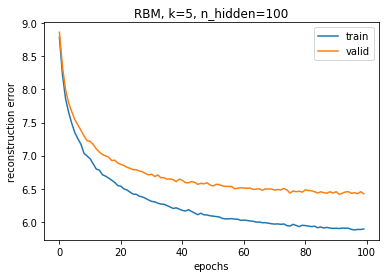

In [6]:
plt.plot(a['train'], label='train')
plt.plot(a['valid'], label='valid')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('reconstruction error')
plt.title(f'RBM, k={k}, n_hidden={n_hidden}')
plt.savefig(f'plot/rbm_plot_epochs_{n_hidden}_k{k}.png')

<h2>Learned features</h2>

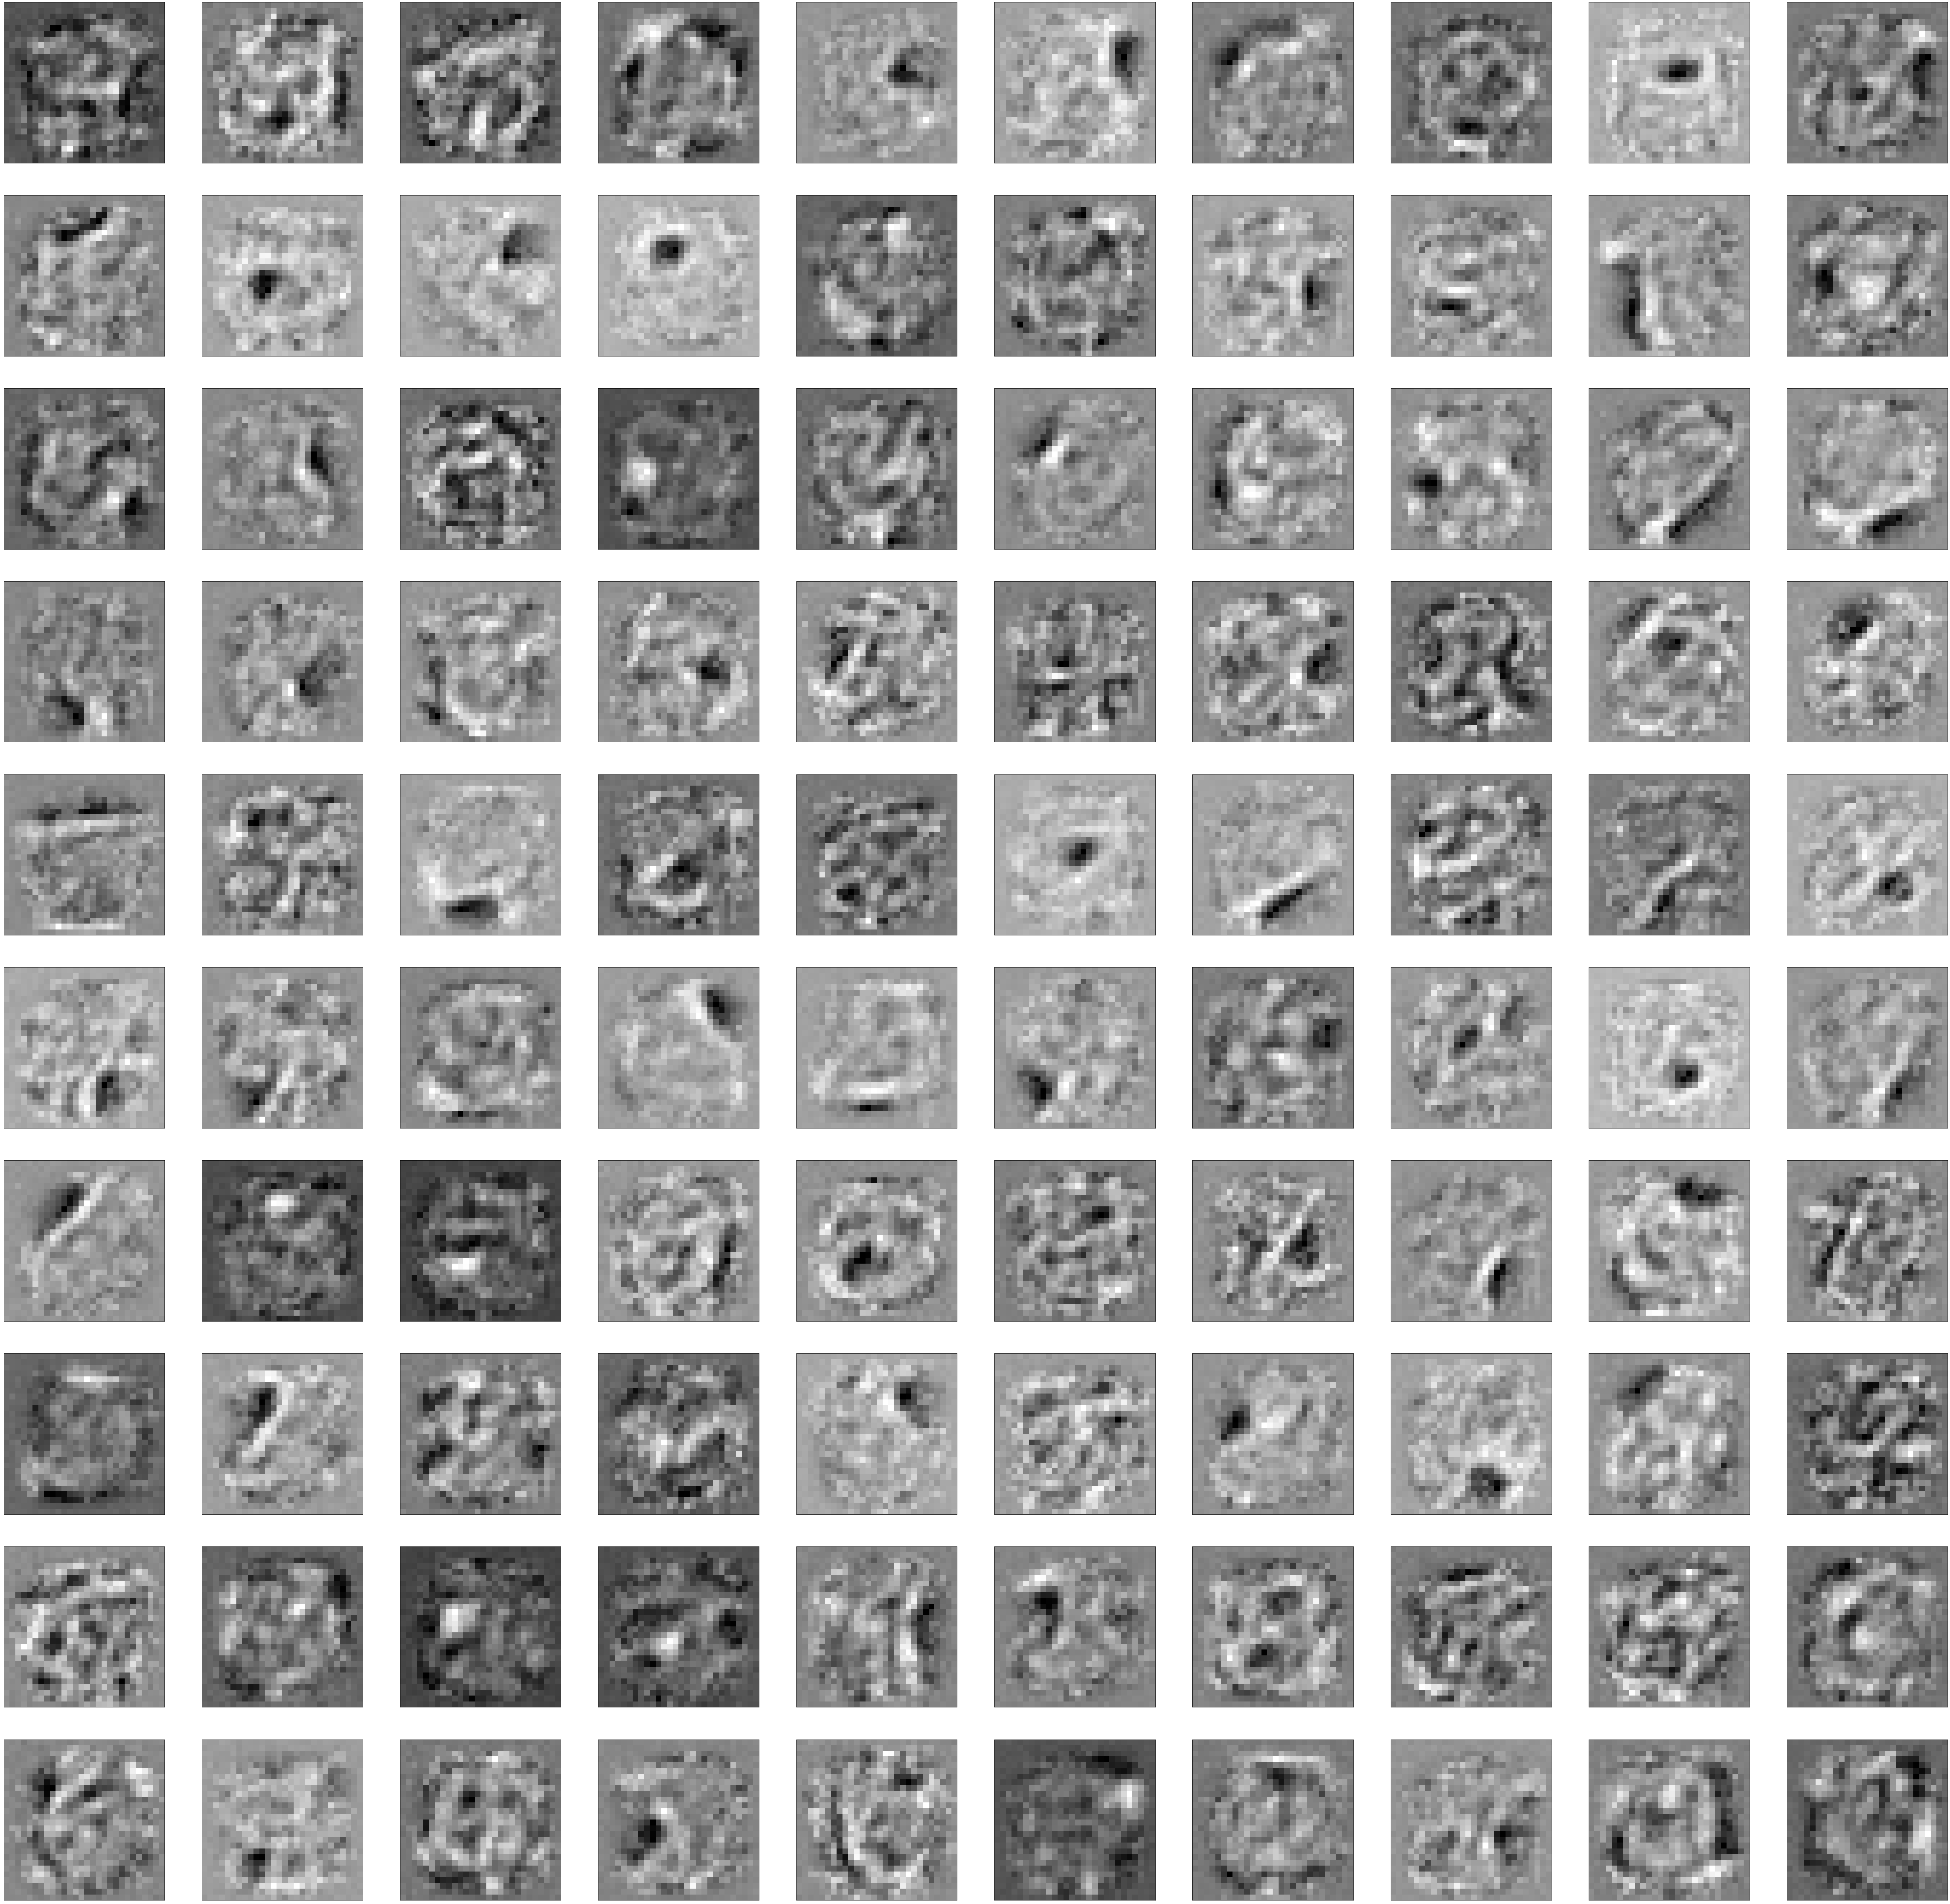

In [8]:
plot_images(rbm.W.reshape(100, 28, 28), path='plot/rbm_features', cols=10)

<h2>Reconstructions</h2>

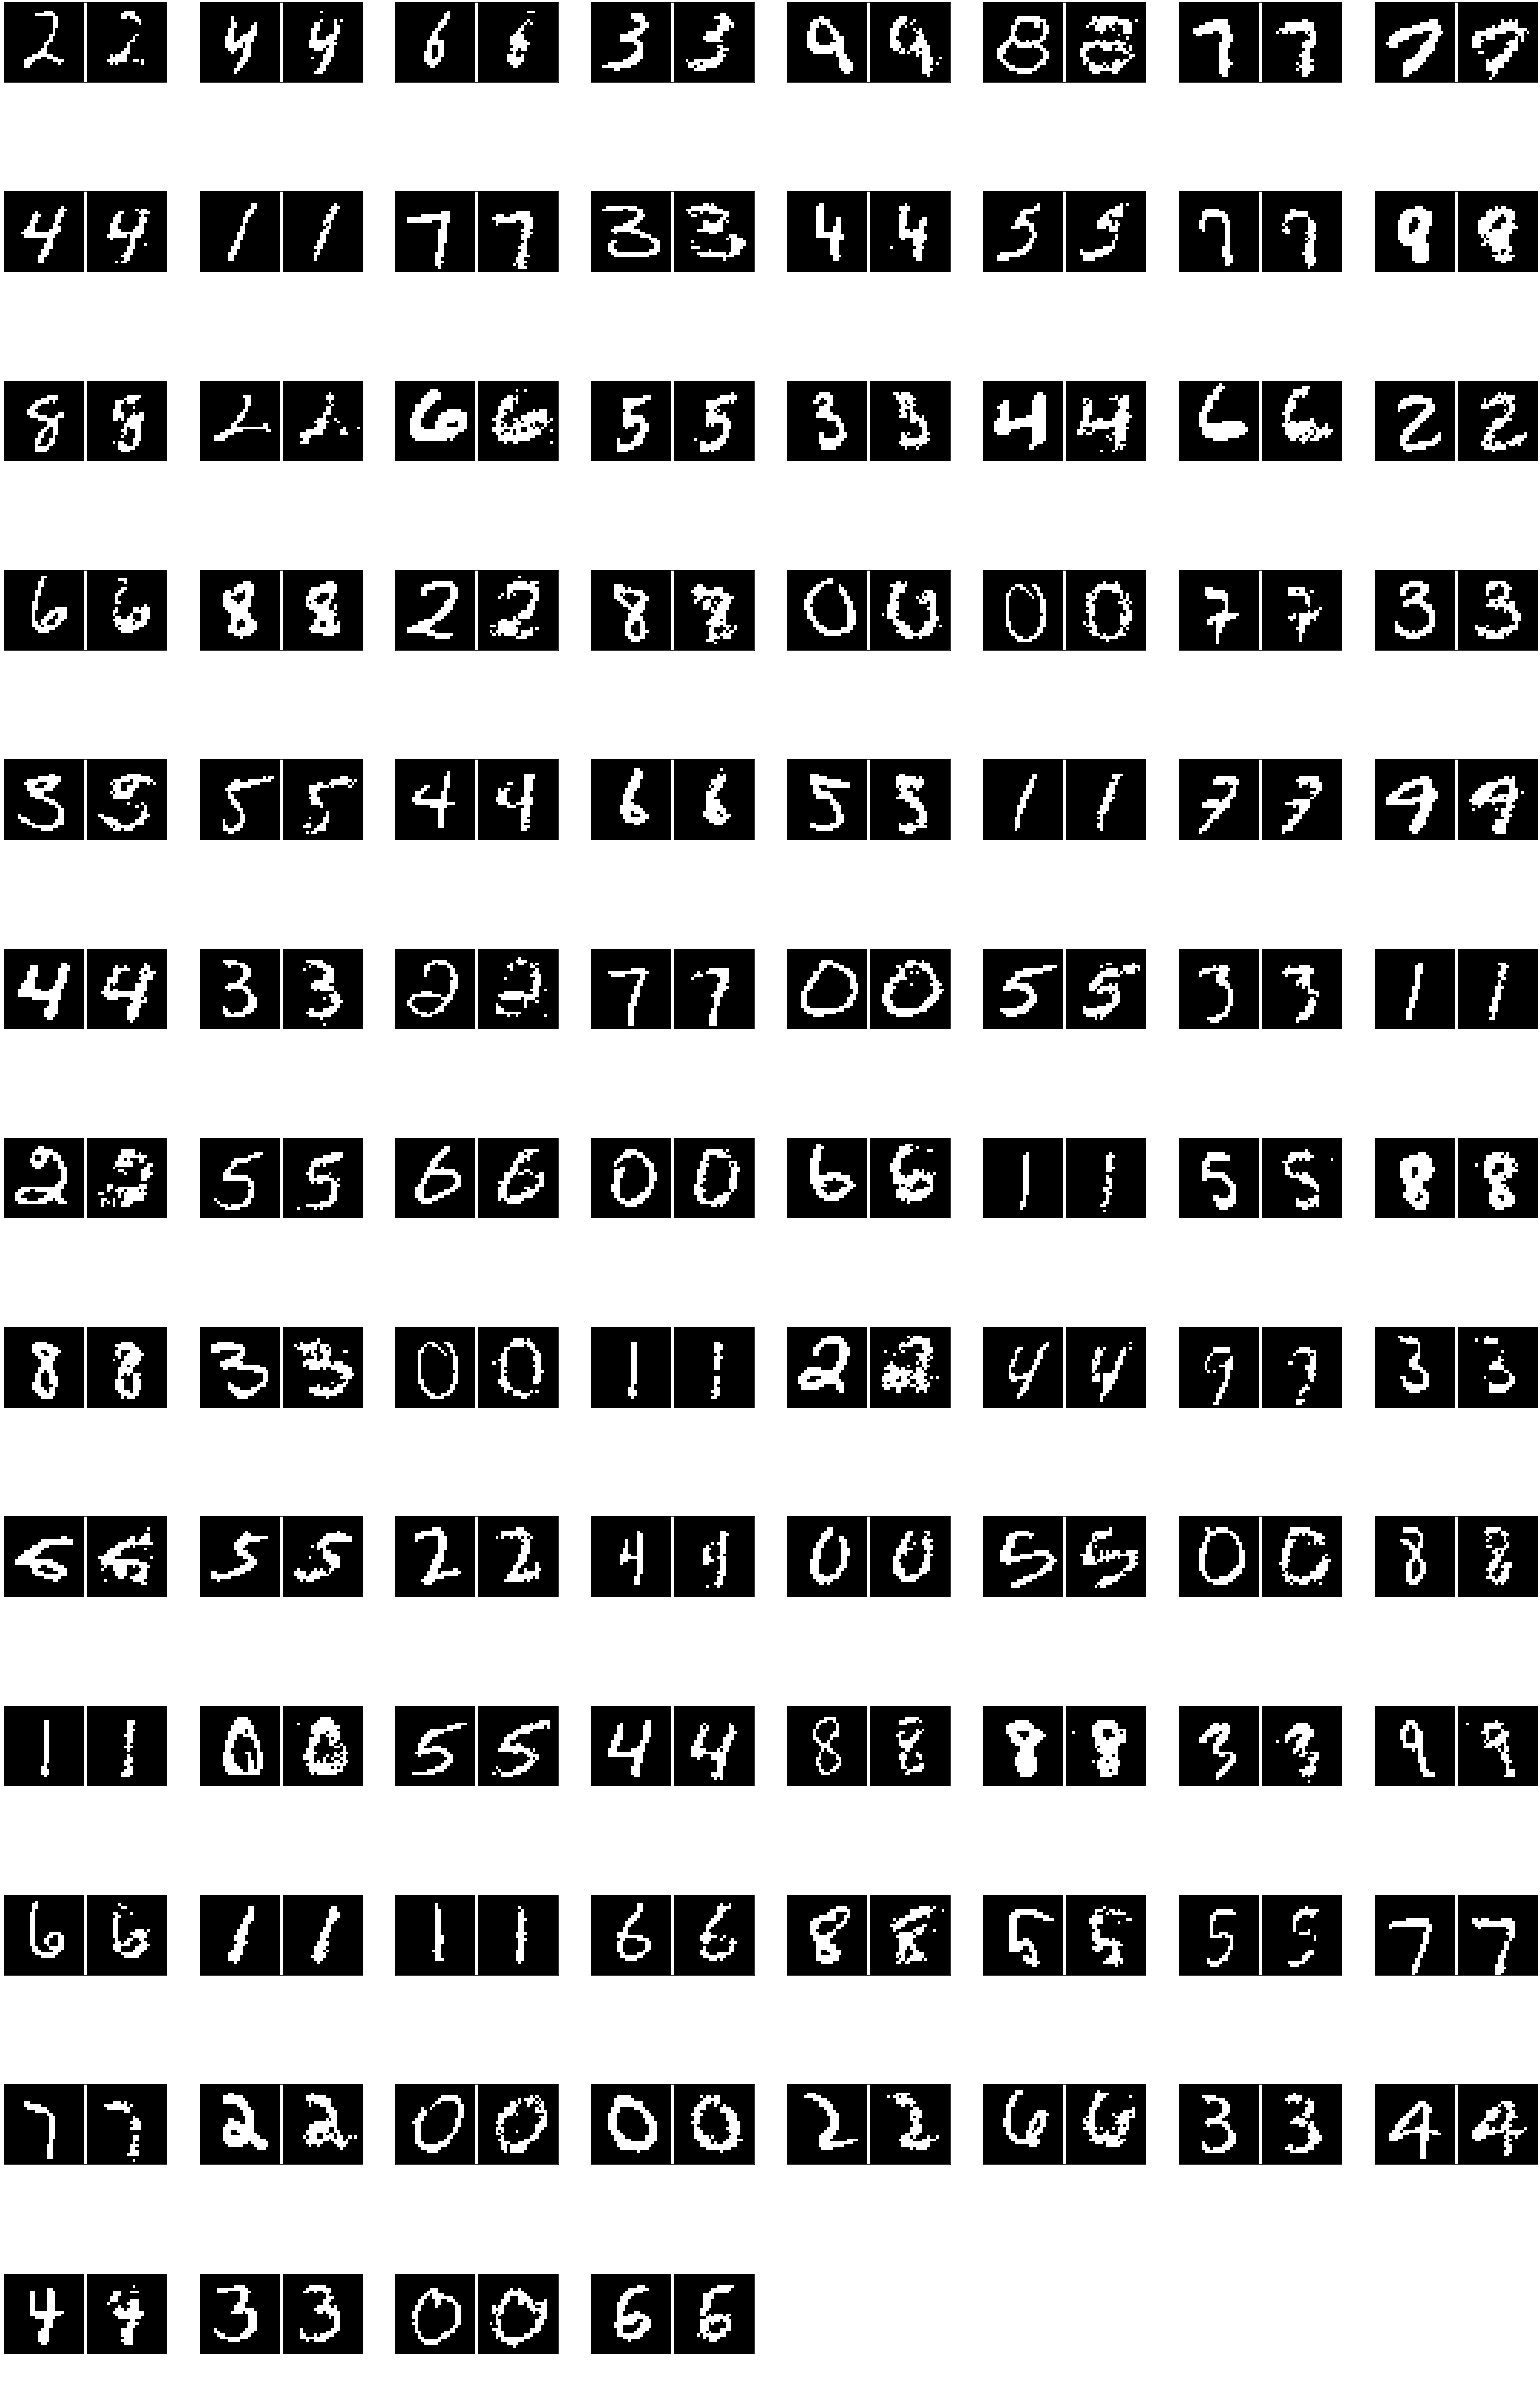

In [9]:
test_data = np.genfromtxt('data/digitstest.txt', delimiter=",")
test_X = binary_data(test_data[:, :-1])
testimages = test_X[np.random.choice(test_X.shape[0], 100)]
ims = []
for x in testimages:
    _, _, h, v, hp, vp = rbm.gibbs_k(x)
    ims.append(v)
ims = np.array(ims).reshape((-1, 28, 28))
testimages = testimages.reshape((-1, 28, 28))
concated = []
for i in range(testimages.shape[0]):
    bar = np.ones((testimages[i].shape[0], 1))
    concated.append(np.hstack([testimages[i], bar, ims[i]]))
concated = np.array(concated)

plot_images(concated, path='plot/rbm_recon', cols=8)